# 7. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [1511]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [1512]:
categories = ['alt.atheism','comp.graphics',\
               'sci.space','talk.religion.misc']

In [1513]:
data = fetch_20newsgroups(subset='all',
    categories=categories, remove=('headers', 'footers', 'quotes'))#, shuffle=True, random_state=42)

In [1514]:
data.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Выведите по 1 тексту для каждой из категории.

In [1515]:
import pandas as pd

In [1516]:
def to_dataframe(data):

    df = pd.DataFrame([data.data, data.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame(data.target_names)
    targets.columns=['category']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    return out

In [1517]:
def load_data(categories = ['alt.atheism','comp.graphics','sci.space','talk.religion.misc'],to_df=True):
    data = fetch_20newsgroups(subset='all',
    categories=categories, remove=('headers', 'footers', 'quotes'))#, shuffle=True, random_state=42)    
    if to_df:
        data = to_dataframe(data)  
    return data

In [1518]:
df = load_data()

In [1519]:
df.head()

,text,target,category
0,My point is that you set up your views as the ...,0,alt.atheism
9,"\n]The ""corrupted over and over"" theory is pr...",0,alt.atheism
14,"\n\nBut, you wouldn't know what red *was*, and...",0,alt.atheism
26,\n\nWell I agree with you in the sense that th...,0,alt.atheism
27,"\n\nSpecifically, which changes are you talkin...",0,alt.atheism


In [1520]:
for cat in df.category.unique():
    row = df[df['category']==cat].head(1)
    print('Category({}): {}\n'.format(row['target'][:1].values[0],cat))  
    print(row['text'][:1].values[0])
    print('-----------------')

Category(0): alt.atheism

My point is that you set up your views as the only way to believe.  Saying 
that all eveil in this world is caused by atheism is ridiculous and 
counterproductive to dialogue in this newsgroups.  I see in your posts a 
spirit of condemnation of the atheists in this newsgroup bacause they don'
t believe exactly as you do.  If you're here to try to convert the atheists 
here, you're failing miserably.  Who wants to be in position of constantly 
defending themselves agaist insulting attacks, like you seem to like to do?!
I'm sorry you're so blind that you didn't get the messgae in the quote, 
everyone else has seemed to.
-----------------
Category(1): comp.graphics


By '8 grey level images' you mean 8 items of 1bit images?
It does work(!), but it doesn't work if you have more than 1bit
in your screen and if the screen intensity is non-linear.

With 2 bit per pixel; there could be 1*c_1 + 4*c_2 timing,
this gives 16 levels, but they are linear if screen intensity

### 2.2 Мешок слов (6 баллов)

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [1521]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [1522]:
X = df['text']
y = df['target'].astype('int')

In [1523]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [1524]:
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train_orig)
X_test = vectorizer.transform(X_test_orig)

In [1525]:
print("Количество слов в словаре: ", len(vectorizer.vocabulary_))
X_train.shape

Количество слов в словаре:  28395


(2370, 28395)

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [1526]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

In [1527]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [1528]:
import numpy as np
import matplotlib.pyplot as plt

In [1529]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

%time search.fit(X_train, y_train)

CPU times: user 235 ms, sys: 136 ms, total: 371 ms
Wall time: 1.88 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [1530]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.8101265822784809, params={'alpha': 1}


In [1531]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [1532]:
y_pred = clf.predict(X_test)

In [1533]:
#Категории для лейблов матрицы ошибок
class_names = df.groupby(['target','category']).count().reset_index().category.values
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

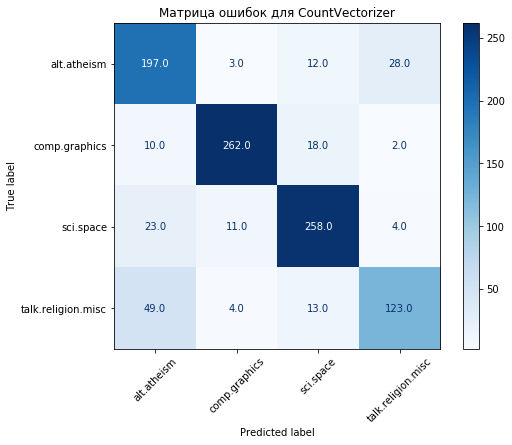

In [1534]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок для CountVectorizer')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [1535]:
print('CountVectorizer\n\n')
print(classification_report(y_test, y_pred, target_names=class_names))

CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.71      0.82      0.76       240
     comp.graphics       0.94      0.90      0.92       292
         sci.space       0.86      0.87      0.86       296
talk.religion.misc       0.78      0.65      0.71       189

          accuracy                           0.83      1017
         macro avg       0.82      0.81      0.81      1017
      weighted avg       0.83      0.83      0.83      1017



--------------- Проверка---------------

Как проверить, что лейблы выставлены правильно? Можно взять количество значений по группам в y_test, просуммировать значения в confusion_matrix по горизонтали, тем самым определив индекс метки, затем по индексу сравнить с df.  

Пример: сумма в 296 в матрице это 3 строка, лейбл указан sci.space, индекс в y_test с 296 == 2, что соответствует sci.space из df

In [1536]:
y_test.value_counts()

2    296
1    292
0    240
3    189
Name: target, dtype: int64

In [1537]:
df.groupby(['target','category']).count()

,,text
target,category,
0,alt.atheism,799
1,comp.graphics,973
2,sci.space,987
3,talk.religion.misc,628


--------------- Проверка завершена---------------

Добавлю сохранение предыдущего отчета, для сравнения с новым

In [1538]:
def report2array(cr,rows=4):
    # classification_report to array
    tmp = list()
    m_avg=0
    r_num=0
    for row in cr.split("\n"):
        if (0 != r_num) and (r_num <= rows+1): #от 2 до 5 строки
            parsed_row = [float(x) for x in row.split("  ") if len(x) > 0]
            if len(parsed_row) > 0:
                tmp.append(parsed_row[1:4])
        if r_num == rows+1+3: # 8 строка macro avg
            parsed_row = [x for x in row.split("  ") if len(x) > 0]
            if len(parsed_row) > 0:
                m_avg =  parsed_row[3]
                break
        r_num+=1
    return np.array(tmp), float(m_avg)

In [1539]:
np.set_printoptions(precision=2)
#Сохраню текущие значения матрицы ошибок
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

In [1540]:
cr_best, macro_avg_best = report2array(classification_report(y_test, y_pred))

In [1541]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories, top=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-top:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

In [1542]:
show_top10(clf, vectorizer, class_names)

alt.atheism: [jesus believe atheism say does think just don people god]
comp.graphics: [available program ftp jpeg images data file edu graphics image]
sci.space: [just data earth time orbit shuttle like launch nasa space]
talk.religion.misc: [lord know bible just don say jehovah jesus people god]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (6 баллов) 

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [1543]:
from sklearn.feature_extraction.text import TfidfTransformer

In [1544]:
tfidf_transformer = TfidfTransformer(use_idf=True)

https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest  
https://stats.stackexchange.com/questions/344571/imputing-the-mean-value-from-the-train-set-into-the-test-set

In [1545]:
X_tfidf_train = tfidf_transformer.fit_transform(X_train)
X_tfidf_test = tfidf_transformer.transform(X_test)

In [1546]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

%time search.fit(X_tfidf_train, y_train)

CPU times: user 185 ms, sys: 8.06 ms, total: 193 ms
Wall time: 426 ms


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [1547]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7616033755274261, params={'alpha': 1}


In [1548]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_tfidf_train, y_train)

y_pred_tfidf = clf.predict(X_tfidf_test)

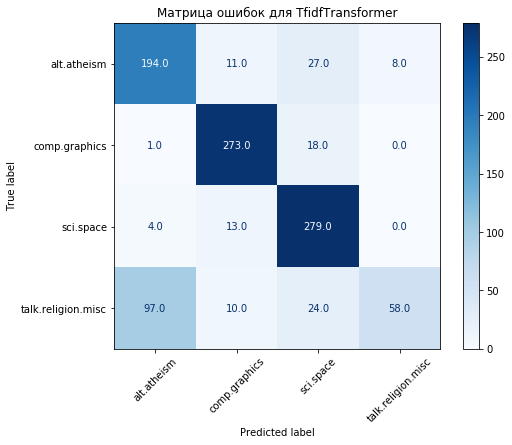

In [1549]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_tfidf_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок для TfidfTransformer')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [1550]:
print('CountVectorizer + tfidf\n\n')
cur_rep = classification_report(y_test, y_pred_tfidf, target_names=class_names)
print(cur_rep)

CountVectorizer + tfidf


                    precision    recall  f1-score   support

       alt.atheism       0.66      0.81      0.72       240
     comp.graphics       0.89      0.93      0.91       292
         sci.space       0.80      0.94      0.87       296
talk.religion.misc       0.88      0.31      0.45       189

          accuracy                           0.79      1017
         macro avg       0.81      0.75      0.74      1017
      weighted avg       0.81      0.79      0.77      1017



In [1551]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred_tfidf))

In [1552]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: -0.07

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[-0.05 -0.01 -0.04]
 [-0.05  0.03 -0.01]
 [-0.06  0.07  0.01]
 [ 0.1  -0.34 -0.26]]


Качество ухудшилось

In [1553]:
show_top10(clf, vectorizer, class_names)

alt.atheism: [believe does atheism say religion just think people don god]
comp.graphics: [need looking format program know files file image thanks graphics]
sci.space: [think don just moon launch orbit shuttle like nasa space]
talk.religion.misc: [koresh know say bible just christian don people jesus god]


In [1554]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred_tfidf))

### 2.4 В чём проблема? (7 баллов)

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

![](https://i.imgur.com/3D5pgrk.png)

Ответ: Основные "проблемы" с реглигией, во первых в атеизме часто встречаются слова из религии, во вторых почему то при определении космоса и графики часть путается с религией, при этом религия не путается с космосом и графикой. Это вероятно говорит о том, что в категории религии специфичные слова имеют бОльший вес, точнее описывают категорию, в отличии от космоса, где проскальзывают слова из религии с весом далеко не на дне. Показательно TN для религии и атеизма, вероятно всего это связано с общими/одинаковыми словами в этих темах, поэтому классификатору сложно их различать. В целом у темы космоса и графики хорошие показатели полноты, точность немного страдает, но если "разобраться" с религией, то думаю станет лучше. Конечно со словарем никак не работали, нужно убирать мусорные и общие слова во всех темах,  а так же проводить анализ словарей по категорям, особенно смотреть на топовые слова. Например из космоса можно убрать слова (think just like) и прочие подобные слова убрать вообще из всех категорий. Из атеизма можно убрать (god, religion), оставив только для религии.

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.

### Дополнительная работа

##### Преобразование слов в хештеги

Посмотрим в целом на словарь. Много цифр, а так же есть слова с "_" вместо пробела.

Сначала разберусь с цифрами. 
 - Цифры состояшие из 4х символов заменю на #года + #века
 - Цифры по примеру 800x600.. заменю на #разрешение
 - все остальные цифры включая шаблоны выше заменю на #цифры
 - Цифры по примеру'6am' или '18:58' заменю на #время
 - Даты заменю на #date

In [1555]:
import re

In [1556]:
vectorizer.get_feature_names()[:500]

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '000005102000',
 '000062david42',
 '0001',
 '00041032',
 '0004136',
 '00041555',
 '0004244402',
 '0004246',
 '00043819',
 '0004422',
 '00044513',
 '00044808',
 '00044939',
 '0004847546',
 '0004988',
 '0005',
 '0005169',
 '0007',
 '0008512',
 '00090711',
 '000usd',
 '0011265',
 '0012',
 '0018',
 '00196',
 '0020',
 '0022',
 '0028',
 '0029',
 '003',
 '0033',
 '0034',
 '0038',
 '0049',
 '006',
 '0065',
 '0094',
 '0098',
 '00index',
 '00pm',
 '01',
 '0100',
 '01272',
 '013846',
 '015',
 '01752',
 '01821',
 '01826',
 '0184',
 '01852',
 '01854',
 '01890',
 '0199',
 '01a',
 '01readme',
 '02',
 '020',
 '0200',
 '02115',
 '02138',
 '02139',
 '02154',
 '02178',
 '0223',
 '023220',
 '0235',
 '0238',
 '023b',
 '024',
 '0245',
 '03',
 '030',
 '0300',
 '03051',
 '031',
 '033',
 '0330',
 '034',
 '04',
 '040',
 '0410',
 '04110',
 '041493003715',
 '0418',
 '0430',
 '045',
 '0451',
 '04g',
 '05',
 '050',
 '0500',
 '0511',
 '05402',
 '05446',
 '0545',
 '054589

In [1557]:
#хеш теги
def RemoveHashtags (txt):  
    out = re.sub(r'#+[\w\d]+\b','',str(txt))
    return out

In [1558]:
#дата
def GetDate (txt):  
    out = re.sub(r'\b\d+[:,\.]\d+[\.]\d+\b',' ##date',str(txt))
    return out

In [1559]:
#года и века
def GetYearCentury (txt):
    def GetCentury (year):
        cen = re.findall(r'\b\d{2,2}',str(year)) #первые 2 числа
        cen = int(cen[0]) + 1
        return '##year ##centry{}'.format(cen)
    out =  re.sub(r'\b[1-2]{1}\d{3}\b',lambda y: GetCentury(y.group(0)),str(txt))
    return out

In [1560]:
#разрешение экрана
def GetResolution (txt):  
    out = re.sub(r'\d+[x]\w+\b',' ##resolution',str(txt))
    return out

In [1561]:
#размер файла
def GetFileSize (txt):  
    out = re.sub(r'\d+[m,M,M,b,B,k,K,K,g,G,G]{1,1}[b,B,y]{1,1}\b',' ##filesize',str(txt))
    return out

In [1562]:
#какой то размер
def GetSomeSize (txt):  
    out = re.sub(r'\b\d+[a-z]{1,3}\b',' ##somesize',str(txt))
    return out

In [1563]:
#время
def GetTime (txt):  
    out = re.sub(r'\d+:\d+[\w,:]+\b',' ##time',str(txt))
    return out

In [1564]:
#сначала цифра/буква, затем буквы и/или цифры
def GetNumbAndLetters (txt):  
    out = re.sub(r'\b\d+[a-z]+\w+\b|[^##]\b[a-z]+\d+\w+\b|[^##]\b[a-z]+\d+\b',' ##numb_lett',str(txt))
    #out = re.sub(r'[^##]\b[a-z]+\d+\b',' ##numb_lett',str(txt))
    return out

In [1565]:
#e-mail
def GetEmail (txt):  
    out = re.sub(r'[@]+[a-z0-9]+|[a-z0-9]+[@]+[a-z0-9]+\b',' ##email',str(txt))
    return out

In [1566]:
#Phone
def GetPhone (txt):  
    out = re.sub(r'\d+[-][-\d]+|[-]\d+[-\d]+',' ##phone',str(txt))
    return out

In [1567]:
#любые цифры, только цифры
def GetNumb(txt):
    out = re.sub(r'\b\d+\b',' ##numb ',str(txt))
    return out

In [1568]:
#слова на латинице от 4х букв убираются
def GetEnWords (txt):
    #out = re.findall(r'\b[^#][a-z]{3,}\b',str(txt.replace('_',''))) #слова на латинице от 3х букв 
    out = re.sub(r'[^#0-9]\b[a-z]{1,4}\b','',str(txt))
    return out

In [1569]:
def re_Parse(txt,cv_parse=True,tresh=True,cv_parse_only=False):
    def process(txt,cv_parse=True):
        if cv_parse:
            txt = txt.replace('_',' ')
            txt = txt.replace('-',' ')
            vectorizer_tmp = CountVectorizer(stop_words='english', token_pattern=r'\b\d+[:,\.]\d+[\.]\d+\b|\d+:\d+[\w,:]+\b|\b\w\w+\b|d+[-][-\d]+|[-]\d+[-\d]+|(?<!\w)@\w+|(?<!\w)##\w+')
            vectorizer_tmp.fit([txt])
            voc = vectorizer_tmp.get_feature_names()
            txt = ' '.join(voc)
            #print(txt + '\n\n')
        if (False == cv_parse_only):
            txt = RemoveHashtags(txt)
            txt = GetDate(txt)
            txt = GetTime(txt)
            txt = GetYearCentury(txt)
            txt = GetResolution(txt)
            txt = GetFileSize(txt)
            txt = GetSomeSize(txt)
            txt = GetEmail(txt)
            #txt = GetPhone(txt)
            txt = GetNumbAndLetters(txt)
            txt = GetNumb(txt)
            txt = GetEnWords(txt)
        return txt
    if tresh:
        if len(txt.split(' ')) > 20: #Если слов в статье больше 20, то берем, иначе встречается ошибка ValueError: empty vocabulary; perhaps the documents only contain stop words
            txt = process(txt,cv_parse)
        else:
            txt=''
    else:
        txt = process(txt,cv_parse)
    return txt

In [1570]:
#Для проверки работы регулярных выражений
re_check = ['00','0000','000005102000','0004246',
 '000062david42','1000k1','a0000','1r0fpv','-89','a3','_38_','10_'
 '101h','000usd','10km','2e','2nd','10m','10mhz','1500kg',
 '0x0','0xc010','1024x768','1024x768x24',
 '1951','2011','1000','1024', 
 '100mb','1GB','110mbytes',
 '15:25:64','6:52',
 '13.02.1999','13.02.99',
 '@andrew','123@article.com',
 'move','end', 'just', 'i',
 '#hashtag', '##centry99',
 'FAX (904) 644-4214 or -0098' , '-800-377-8287',
 '_____________________',
 '___samuel___',
  ]
re_check = ' '.join(re_check)
re_Parse(re_check,tresh=False)

'  ##numb   ##numb   ##numb   ##numb_lett  ##numb   ##somesize  ##numb   ##resolution  ##resolution  ##numb  ##year ##centry11  ##numb_lett  ##filesize  ##somesize ##year ##centry11  ##resolution  ##resolution  ##somesize  ##somesize  ##somesize  ##numb_lett  ##numb   ##date  ##date  ##somesize  ##time ##year ##centry20  ##filesize  ##numb_lett ##year ##centry21  ##somesize  ##somesize  ##numb   ##numb   ##numb   ##numb   ##time  ##numb   ##numb   ##numb   ##numb   ##email ##numb_lett ##numb_lett article hashtag samuel'

Сформирую новый столбец с текстом, который будет содержать только слова, затем на основе него составлю новый словарь.

In [1571]:
df['text_f3'] = df['text'].apply(lambda r: re_Parse(r,cv_parse=True,tresh=True,cv_parse_only=False))

In [1572]:
#text_f3 == nan, это статьи, у которых мало текста или вообще нет или он состоит только из стоп слов
df.isnull().sum()

text        0
target      0
category    0
text_f3     0
dtype: int64

In [1573]:
df.dropna(inplace=True)

In [1574]:
df[['text','text_f3']].head()

,text,text_f3
0,My point is that you set up your views as the ...,agaist atheism atheists attacks bacause believ...
9,"\n]The ""corrupted over and over"" theory is pr...",believe brothers changed closed comparison cop...
14,"\n\nBut, you wouldn't know what red *was*, and...",applicable certainly couldn discuss judge meri...
26,\n\nWell I agree with you in the sense that th...,adam agree avoid behaviour criminal deleted ev...
27,"\n\nSpecifically, which changes are you talkin...",##numb arguing changes interpreted larger mo...


In [1575]:
X = df['text_f3']
y = df['target'].astype('int')

In [1576]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [1577]:
vectorizer_f3 = CountVectorizer(stop_words='english',token_pattern=r'\b\d+[:,\.]\d+[\.]\d+\b|\d+:\d+[\w,:]+\b|\b\w\w+\b|d+[-][-\d]+|[-]\d+[-\d]+|(?<!\w)@\w+|(?<!\w)##\w+')
X_train_f3 = vectorizer_f3.fit_transform(X_train_orig)
X_test_f3 = vectorizer_f3.transform(X_test_orig)

#X_train_f3 = tfidf_transformer.fit_transform(X_train_f3)
#X_test_f3 = tfidf_transformer.transform(X_test_f3)

In [1578]:
vectorizer_f3.get_feature_names()

['##centry11',
 '##centry12',
 '##centry13',
 '##centry14',
 '##centry15',
 '##centry16',
 '##centry17',
 '##centry18',
 '##centry19',
 '##centry20',
 '##centry21',
 '##centry22',
 '##centry23',
 '##centry24',
 '##centry25',
 '##centry26',
 '##centry27',
 '##centry28',
 '##centry29',
 '##centry30',
 '##date',
 '##email',
 '##filesize',
 '##numb',
 '##numb_lett',
 '##resolution',
 '##somesize',
 '##time',
 '##year',
 'aangeboden',
 'aangegeven',
 'aantal',
 'aaoepp',
 'aaplay',
 'aarnet',
 'aaroundpluto',
 'aavso',
 'aawin',
 'ab',
 'abandon',
 'abandoned',
 'abandoning',
 'abandons',
 'abbreviated',
 'abbreviation',
 'abbreviations',
 'abdel',
 'abducted',
 'abdullah',
 'aberdeen',
 'aberration',
 'aberrations',
 'abhor',
 'abhorrence',
 'abhorrent',
 'abide',
 'abiding',
 'abilities',
 'ability',
 'abiliy',
 'abilty',
 'abingdon',
 'abiogenesis',
 'abiogenesists',
 'abjuring',
 'ablazing',
 'able',
 'ablex',
 'ablutions',
 'aboard',
 'abode',
 'abolish',
 'abolished',
 'abolishment',


In [1579]:
print('Слов в словаре до формирования хештегов: {}'.format(len(vectorizer.get_feature_names())))
print('Слов в словаре после формирования хештегов: {}'.format(len(vectorizer_f3.get_feature_names())))

Слов в словаре до формирования хештегов: 28395
Слов в словаре после формирования хештегов: 21157


In [1580]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7641350210970465, params={'alpha': 1}


In [1581]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [1582]:
y_pred = clf.predict(X_test_f3)

In [1583]:
print('Формирование хештегов + CountVectorizer\n\n')
cur_rep = classification_report(y_test, y_pred, target_names=class_names)
print(cur_rep)

Формирование хештегов + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.74      0.74      0.74       240
     comp.graphics       0.90      0.81      0.85       292
         sci.space       0.69      0.89      0.78       296
talk.religion.misc       0.81      0.56      0.66       189

          accuracy                           0.77      1017
         macro avg       0.78      0.75      0.76      1017
      weighted avg       0.78      0.77      0.77      1017



In [1584]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [1585]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: 0.02

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[ 0.08 -0.07  0.02]
 [ 0.01 -0.12 -0.06]
 [-0.11 -0.05 -0.09]
 [-0.07  0.25  0.21]]


In [1586]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: -0.05

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[ 0.03 -0.08 -0.02]
 [-0.04 -0.09 -0.07]
 [-0.17  0.02 -0.08]
 [ 0.03 -0.09 -0.05]]


In [1587]:
show_top10(clf, vectorizer_f3, class_names)

alt.atheism: [thing right point really things religion believe think people ##numb]
comp.graphics: [##centry20 image program thanks graphics ##year ##somesize ##date ##numb_lett ##numb]
sci.space: [orbit people think ##time space ##centry20 ##numb_lett ##somesize ##year ##numb]
talk.religion.misc: [really bible jesus point believe ##year think people ##time ##numb]


In [1588]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

In [1589]:
tfidf_transformer = TfidfTransformer(use_idf=True)
X_tfidf_train_f3 = tfidf_transformer.fit_transform(X_train_f3)
X_tfidf_test_f3 = tfidf_transformer.transform(X_test_f3)

In [1590]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_tfidf_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7126582278481013, params={'alpha': 1}


In [1591]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_tfidf_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [1592]:
y_pred_tfidf = clf.predict(X_tfidf_test_f3)

In [1593]:
cur_rep = classification_report(y_test, y_pred_tfidf , target_names=class_names)
print('Формирование хештегов + CountVectorizer + tfidf\n\n')
print(cur_rep)

Формирование хештегов + CountVectorizer + tfidf


                    precision    recall  f1-score   support

       alt.atheism       0.67      0.74      0.70       240
     comp.graphics       0.87      0.83      0.85       292
         sci.space       0.66      0.93      0.77       296
talk.religion.misc       0.95      0.29      0.44       189

          accuracy                           0.74      1017
         macro avg       0.79      0.70      0.69      1017
      weighted avg       0.78      0.74      0.72      1017



In [1594]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred_tfidf))

In [1595]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: -0.07

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[-0.07  0.   -0.04]
 [-0.03  0.02  0.  ]
 [-0.03  0.04 -0.01]
 [ 0.14 -0.27 -0.22]]


In [1596]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred_tfidf))

### Top и Tail слова

Посмотрим на Top и Tail слова по tfidf общего словаря

In [1597]:
#Слова и их веса
def token_weight_df (dic, prefix):    
    token_weight = pd.DataFrame.from_dict(dic, orient='index').reset_index()
    token_weight.columns=(prefix,'weight_'+prefix)
    token_weight = token_weight.sort_values(by='weight_'+prefix, ascending=False)
    return token_weight

In [1598]:
#объединение слов и весов
rr = dict(zip(vectorizer_f3.get_feature_names(), tfidf_transformer.idf_))

In [1599]:
rr_voc = token_weight_df(rr,'word')

In [1600]:
rr_voc.head(10)

,word,weight_word
9412,inductively,8.07792
15863,researching,8.07792
8720,hintmatt,8.07792
15867,resemblence,8.07792
8722,hippi,8.07792
8723,hipsaddon,8.07792
8726,hiromasa,8.07792
8727,hirsch,8.07792
8728,hispasat,8.07792
8729,hissy,8.07792


In [1601]:
rr_voc.tail(10)

,word,weight_word
1899,believe,3.315746
19025,things,3.294604
14082,point,3.191337
17530,space,3.143446
28,##year,3.101186
26,##somesize,3.097744
24,##numb_lett,3.047482
13617,people,2.762254
19027,think,2.691134
23,##numb,2.215710


Уберу из словаря часто встречающиеся и редко встречающиеся слова

max_df = 0.50 означает «игнорировать термины, встречающиеся в более чем 50% документов »  
max_df = 25 означает «игнорировать термины, встречающиеся в более чем 25 документах »  
  

min_df = 0.01 означает «игнорировать термины, встречающиеся менее чем в 1% документов »  
min_df = 5 означает «игнорировать термины, встречающиеся менее чем в 5 документах »  

In [1602]:
X = df['text']
#X = df['text_f3']
y = df['target'].astype('int')
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [1603]:
cv_max_df=0.16 #Параметры для CountVectorizer default 1.0
cv_min_df=2 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer default=(1, 1)

In [1604]:
vectorizer_f3_w = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                             stop_words='english',
                             token_pattern=r'\b\d+[:,\.]\d+[\.]\d+\b|\d+:\d+[\w,:]+\b|\b\w\w+\b|d+[-][-\d]+|[-]\d+[-\d]+|(?<!\w)@\w+|(?<!\w)##\w+')

In [1605]:
X_train_f3 = vectorizer_f3_w.fit_transform(X_train_orig)
X_test_f3 = vectorizer_f3_w.transform(X_test_orig)

In [1606]:
print('Слов в словаре после max_df/min_df: {}'.format(len(vectorizer_f3_w.get_feature_names())))

Слов в словаре после max_df/min_df: 14679


In [1607]:
rr = dict(zip(vectorizer_f3_w.get_feature_names(), tfidf_transformer.idf_))
rr_voc = token_weight_df(rr,'word')

In [1608]:
rr_voc.head(10)

,word,weight_word
5918,forward,8.07792
5096,endorse,8.07792
14181,voltage,8.07792
12726,stroke,8.07792
9199,newborns,8.07792
5088,encyclopedia,8.07792
5087,encouraging,8.07792
5086,encourages,8.07792
5085,encouraged,8.07792
5084,encourage,8.07792


In [1609]:
rr_voc.tail(10)

,word,weight_word
14632,yesterday,3.482800
1987,atlanta,3.452947
9,-0900,3.443191
1899,ashes,3.315746
14082,vhs,3.191337
28,-1500,3.101186
26,-1441,3.097744
24,-14,3.047482
13617,try,2.762254
23,-135,2.215710


In [1610]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.8135021097046413, params={'alpha': 1}


In [1611]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [1612]:
y_pred = clf.predict(X_test_f3)

In [1613]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Хештеги + CountVectorizer + max_df/min_df \n\n')
print(cur_rep)

Хештеги + CountVectorizer + max_df/min_df 


                    precision    recall  f1-score   support

       alt.atheism       0.70      0.81      0.75       240
     comp.graphics       0.93      0.90      0.91       292
         sci.space       0.86      0.88      0.87       296
talk.religion.misc       0.78      0.65      0.71       189

          accuracy                           0.82      1017
         macro avg       0.82      0.81      0.81      1017
      weighted avg       0.83      0.82      0.82      1017



In [1614]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [1615]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: 0.12

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[ 0.03  0.07  0.05]
 [ 0.06  0.07  0.06]
 [ 0.2  -0.05  0.1 ]
 [-0.17  0.36  0.27]]


In [1616]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: 0.00

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[-0.01 -0.01 -0.01]
 [-0.01  0.   -0.01]
 [ 0.    0.01  0.01]
 [ 0.    0.    0.  ]]


In [1617]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

Вывод: моя "очистка слов" и преобразование чисел в теги "в лоб" не дала улучшения, но и сильного ухудшения, при этом использование max_df/min_df не ухудшило лучшую модель, но я выкинул почти 14 тыс слов, что сделало модель быстрее. Необходим более глубокий анализ и более тонкие настройки использования хештегов. 

### Отдельные словари для каждой категории

Идея в том,чтобы использовать max_df не на всем корпусе слов, а для каждой категории свой. Сделаю отдельные словари на каждую категорию, затем попробую из каждой категории взять свой процент топ слов по весу и затем объединить все в один словарь. 

In [1618]:
import itertools

In [1619]:
def vocs_for_category(df,topwords_perc=[1,1,1,1],cv_max_df=1.0,cv_min_df=1,cv_ngram=(1,1),col_name='text_f3',cv_stopwords=True, groups=class_names):
    '''
    Формирует словарь с топ словами по каждой категории
    topwords_perc - сколько процентов в каждой категории брать в словарь, сверху от топа по tfidf (1-100%)
    '''   
    cv_max_df=cv_max_df #Параметры для CountVectorizer default 1.0
    cv_min_df=cv_min_df #Параметры для CountVectorizer default 1
    cv_ngram_range=cv_ngram #Параметры для CountVectorizer default=(1, 1)
    vocs = {}
    for i,g in enumerate(groups):
        X = df[df.target == i][col_name]
        y = df[df.target == i]['target']
        
        train, test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
        
        if (cv_stopwords):
            vect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                            stop_words='english')
        else:
            vect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)
            
        tfidf = TfidfTransformer()
        
        vect_c = vect.fit_transform(train)
        tfidf.fit_transform(vect_c)
        
        rr = dict(zip(vect.get_feature_names(), tfidf.idf_))
        rr_voc = token_weight_df(rr,'word')

        voc = rr_voc.iloc[:int(rr_voc.shape[0]*topwords_perc[i])]['word'].values
        
        vocs["voc_{}".format(i)]=voc
        
        #print('Категория: {}, слов в исходном словаре: {}, слов в топ словаре: {}.'.format(g,len(vect.get_feature_names()),len(voc)))
    return vocs

In [1620]:
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

In [1621]:
vocs = vocs_for_category(df.copy(), topwords_perc=[0.8,0.90,0.95,0.7],cv_max_df=1.0,cv_min_df=1)

In [1622]:
#сформирую итоговый список слов для мешка слов
voc_data = list(itertools.chain.from_iterable([*vocs.values()]))
len(voc_data)

27938

In [1623]:
#X = df['text_f3']
X = df['text']
y = df['target'].astype('int')
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [1624]:
cv_max_df=1.0 #Параметры для CountVectorizer default 1.0
cv_min_df= 1 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer default=(1, 1)

vectorizer = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                            stop_words='english',
                            token_pattern=r'\b\d+[:,\.]\d+[\.]\d+\b|\d+:\d+[\w,:]+\b|\b\w\w+\b|d+[-][-\d]+|[-]\d+[-\d]+|(?<!\w)@\w+|(?<!\w)##\w+')

X_voc = vectorizer.fit(voc_data)

X_train = X_voc.transform(X_train_orig)
X_test = X_voc.transform(X_test_orig)

#X_tfidf_train = tfidf_transformer.fit_transform(X_train)
#X_tfidf_test = tfidf_transformer.transform(X_test)

In [1625]:
len(vectorizer.vocabulary_)

19760

In [1626]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7738396624472574, params={'alpha': 1}


In [1627]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [1628]:
y_pred = clf.predict(X_test)

In [1629]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Словарь из топа категорий + CountVectorizer\n\n')
print(cur_rep)

Словарь из топа категорий + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.68      0.79      0.73       240
     comp.graphics       0.90      0.88      0.89       292
         sci.space       0.80      0.82      0.81       296
talk.religion.misc       0.74      0.57      0.64       189

          accuracy                           0.78      1017
         macro avg       0.78      0.76      0.77      1017
      weighted avg       0.79      0.78      0.78      1017



In [1630]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [1631]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: -0.04

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[-0.02 -0.02 -0.02]
 [-0.03 -0.02 -0.02]
 [-0.06 -0.06 -0.06]
 [-0.04 -0.08 -0.07]]


In [1632]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: -0.04

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[-0.03 -0.03 -0.03]
 [-0.04 -0.02 -0.03]
 [-0.06 -0.05 -0.05]
 [-0.04 -0.08 -0.07]]


In [1633]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

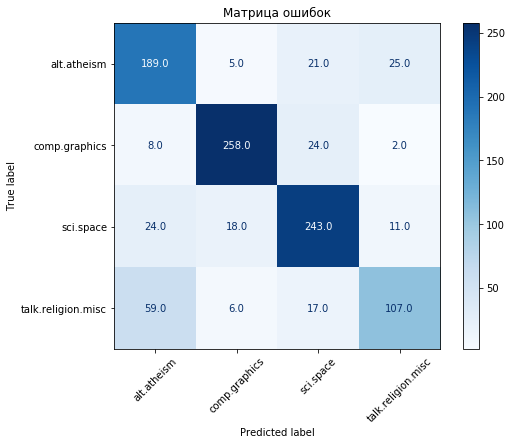

In [1634]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [1635]:
show_top10(clf, X_voc, class_names, top=10)

alt.atheism: [exist book argument did atheist bible belief evidence don god]
comp.graphics: [don computer display package color bit format software images graphics]
sci.space: [station venus spacecraft solar mission don satellite orbit shuttle launch]
talk.religion.misc: [objective evidence father christians christian elohim did bible don god]


Как оказалось, лучший результат при использовании 100% слов каждой категории.

### Исключение слов из статей  
У меня уже есть отдельные словари для каждой из статей (vocs), попробую исключить повторяющиеся слова из статей. К примеру из атеизма исключить слова, которые есть и в атеизме и в религии, тем самым оставив и там и там только уникальные слова для этих статей.

In [1636]:
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

In [1637]:
def CelarSameWords(bow=voc_data, vocs=vocs, cats=class_names):
    '''
    Ищет одинаковые слова в каждой категории и исключает их из общего BOW
    В итоге в BOW только "уникальные" слова для каждой категории
    '''
    keys_count = len(vocs.keys())
    keys_indx = list(range(0,keys_count))
    for k in keys_indx:
        keys_for_clear =  keys_indx.copy()
        keys_for_clear.remove(k) #индексы словарей для поиска одинаковых слов и очистке
        for key_for_clear in keys_for_clear:
            #одинаковые слова 2х категорий
            same_words = set(vocs["voc_{}".format(k)]) & set(vocs["voc_{}".format(key_for_clear)])
            #исключею из общего словаря одинаковые слова
            bow = list(set(bow)-same_words)
    return bow

--------Тест-----

In [1638]:
#Тестовый набор данных
df_tmp = pd.DataFrame()
df_tmp['text_f3'] = 2*['aarr aagg aarr aaaa', 'ggss gggg ggggg aagg', 'ggss ssss sssss ssrr', 'aarr ssrr aarr rrrr'] 
df_tmp['target'] = 2*[0,1,2,3]
df_tmp.head(4)

,text_f3,target
0,aarr aagg aarr aaaa,0
1,ggss gggg ggggg aagg,1
2,ggss ssss sssss ssrr,2
3,aarr ssrr aarr rrrr,3


In [1639]:
#словарь из слов каждой категории
vocs_tmp = vocs_for_category(df=df_tmp.copy())
vocs_tmp

{'voc_0': array(['aaaa', 'aagg', 'aarr'], dtype=object),
 'voc_1': array(['aagg', 'gggg', 'ggggg', 'ggss'], dtype=object),
 'voc_2': array(['ggss', 'ssrr', 'ssss', 'sssss'], dtype=object),
 'voc_3': array(['aarr', 'rrrr', 'ssrr'], dtype=object)}

In [1640]:
#словарь объединенный один список
voc_data_tmp = list(itertools.chain.from_iterable([*vocs_tmp.values()]))
voc_data_tmp

['aaaa',
 'aagg',
 'aarr',
 'aagg',
 'gggg',
 'ggggg',
 'ggss',
 'ggss',
 'ssrr',
 'ssss',
 'sssss',
 'aarr',
 'rrrr',
 'ssrr']

In [1641]:
#Только уникальные слова, не повторяющиеся в других категориях
bow_uniq_tmp = CelarSameWords(bow=voc_data_tmp, vocs=vocs_tmp, cats=class_names)
bow_uniq_tmp

['aaaa', 'ssss', 'sssss', 'ggggg', 'gggg', 'rrrr']

In [1642]:
vectorizer_tmp = CountVectorizer(vocabulary=bow_uniq_tmp)
vectorizer_tmp.vocabulary

['aaaa', 'ssss', 'sssss', 'ggggg', 'gggg', 'rrrr']

In [1643]:
vectorizer_tmp.transform(['aarr aagg aarr aaaa']).toarray()

array([[1, 0, 0, 0, 0, 0]])

#-------Тест-завершен----

Перебор параметров

In [1644]:
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [1645]:
#перебор параметров подготовки словаря
pipe_flag=False

if pipe_flag:
    for topwords_perc in [[1,1,1,1],[0.99,0.99,0.99,0.99],[0.98,0.98,0.98,0.98],[0.97,0.97,0.97,0.97],[0.5,0.99,0.99,0.99],[0.2,0.99,0.99,0.99]]:
        #получаю словарь из процента топ слов каждой категории
        vocs = vocs_for_category(df.copy(), topwords_perc=topwords_perc,cv_max_df=1.0,cv_min_df=1)
        #формирую итоговый список слов для мешка слов
        voc_data = list(itertools.chain.from_iterable([*vocs.values()]))
        print('\n\n===Старт с параметрами: {}'.format(topwords_perc))
        #убираю слова, которые есть в словаре каждой категории. в каждой категории только слова которые встречаются в этой категории
        bow_uniq = CelarSameWords(voc_data.copy())
        print('   Слов было: {}, стало:{}'.format(len(voc_data),len(bow_uniq)))
        #формирую пайплан
        pipeline = Pipeline([
            ('count_vectorizer', CountVectorizer(
              vocabulary=bow_uniq, #использую свой подготовленный словарь
            )),
            ('clf', MultinomialNB())
        ])
        parameters = {
            'count_vectorizer__max_df': [1.0,0.02,0.05,0.09,0.12,0.15,0.25],
            'count_vectorizer__min_df': [1,2,3,4,5],
            'count_vectorizer__ngram_range': [(1, 1),(1, 2),(1, 3),(2, 2),(2, 3)],
            'clf__alpha': [1,2,3]
        }
    
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        search = GridSearchCV(pipeline, parameters , cv=cv, verbose=0,n_jobs=2, scoring='accuracy')                    
    
        %time search.fit(X_train_orig, y_train)
        print("### BEST: score={}, params={}".format(search.best_score_, search.best_params_))

Модель по лучшим параметрам:

In [1646]:
X = df['text']
#X = df['text_f3']
y = df['target'].astype('int')
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [1647]:
best_topwords_perc = [1,1,1,1]
cv_max_df=1.0 #Параметры для CountVectorizer default 1.0
cv_min_df= 1 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer default=(1, 1)
best_alpha = 1

In [1648]:
vocs = vocs_for_category(df.copy(),col_name='text',topwords_perc=best_topwords_perc,cv_max_df=1.0,cv_min_df=1)

In [1649]:
#сформирую итоговый список слов для мешка слов
voc_data = list(itertools.chain.from_iterable([*vocs.values()]))
len(voc_data)

43623

In [1650]:
#Слова уникальные для каждой категории, не повторяющиеся в других
bow_uniq = CelarSameWords(voc_data.copy())
print('Было слов: {}, стало:{}'.format(len(voc_data),len(bow_uniq)))

Было слов: 43623, стало:21743


In [1651]:
vectorizer = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                             vocabulary=bow_uniq,
                            stop_words='english')

X_train = vectorizer.transform(X_train_orig)
X_test =  vectorizer.transform(X_test_orig)

#X_train = tfidf_transformer.fit_transform(X_train)
#X_test = tfidf_transformer.transform(X_test)

In [1652]:
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [1653]:
y_pred = clf.predict(X_test)

In [1654]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [1655]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Словарь с вычетом повторяющихся слов + CountVectorizer\n\n')
print(cur_rep)

Словарь с вычетом повторяющихся слов + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.75      0.80      0.77       260
     comp.graphics       0.91      0.91      0.91       293
         sci.space       0.87      0.88      0.88       293
talk.religion.misc       0.74      0.65      0.70       171

          accuracy                           0.83      1017
         macro avg       0.82      0.81      0.81      1017
      weighted avg       0.83      0.83      0.83      1017



In [1656]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: 0.00

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[ 0.04 -0.02  0.01]
 [-0.03  0.01 -0.01]
 [ 0.01  0.01  0.02]
 [-0.04  0.   -0.01]]


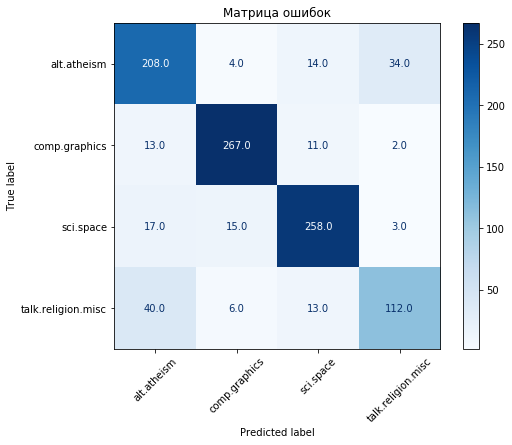

In [1657]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

### Посмотрю подробнее на статьи предсказанные ошибочно

In [1658]:
#Нужно посмотреть на тексты, которые ошибочно предсказываеются. например в религии

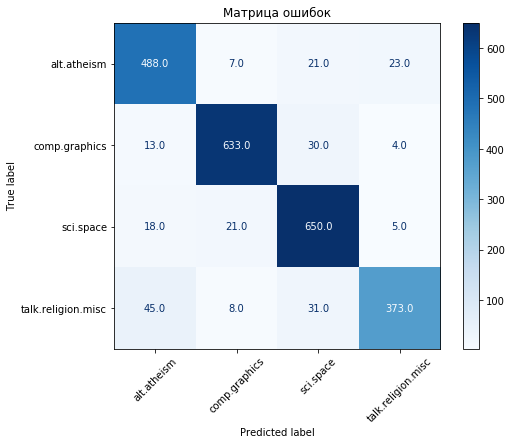

In [1659]:
#Возьму тренеровочные данные, на которых проводил обучение

y_pred = clf.predict(X_train)

fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [1721]:
train_data_for_x = X_train
train_data_for_y = y_train


df_y_test = train_data_for_y.reset_index()
df_y_test['pred'] = clf.predict(train_data_for_x)
df_y_test.head()

,index,target,pred
0,47,0,2
1,3053,2,2
2,380,1,2
3,1884,0,2
4,328,1,2


In [1661]:
df_y_test.groupby(['target','pred'])['pred'].count()

target  pred
0       0       488
        1         7
        2        21
        3        23
1       0        13
        1       633
        2        30
        3         4
2       0        18
        1        21
        2       650
        3         5
3       0        45
        1         8
        2        31
        3       373
Name: pred, dtype: int64

In [1662]:
#Объединю данные, чтобы посмотреть текст статей
df_y_test = df_y_test.join(df,rsuffix='_y',on='index')
df_y_test.drop('target_y',axis=1,inplace=True)
df_y_test.head(2)

,index,target,pred,text,category,text_f3
0,47,0,0,"\n\n AH! But what, exactly, is ""inherentl...",alt.atheism,abhorrent absolutely absolutism agree alike al...
1,3053,2,2,\nIt would be nice if someone here from the HS...,sci.space,aerospace arrays begin bringing built center c...


In [1663]:
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

In [1664]:
#Возьму атеизм как target и графику как pred
df_ag = df_y_test[(df_y_test['target']==0) & (df_y_test['pred']==1)]
df_ag.head()

,index,target,pred,text,category,text_f3
147,1608,0,1,[Frank's solution deleted.]\n\nIf you have acc...,alt.atheism,access check completly contact deleted frank n...
835,444,0,1,"[By default, followups to 3 newsgroups.]\n\nA ...",alt.atheism,
906,269,0,1,dps@nasa.kodak.com Pontificated: \n\nCan you c...,alt.atheism,answer example kodak pontificated receive
969,1827,0,1,"\n""Manufacturing Consent,"" a film about the me...",alt.atheism,##year ##centry20 ##numb_lett ##numb ##num...
1496,121,0,1,\nTail-recursive functions in Scheme are at le...,alt.atheism,assembler compilers doesn efficient functions ...


In [1665]:
#Посмотрим подробнее на текст
df_ag.loc[147]['text']

"[Frank's solution deleted.]\n\nIf you have access to telnet, contact nyx.cs.du.edu.  It's a public access\nUnix system, completly free, and all you need to for access is a verifiable\nform of ID (I think he requires a notarized copy of a picture, or a check, or\nsome such)."

In [1666]:
df_ag.loc[969]['text']

'\n"Manufacturing Consent," a film about the media. You alternative movie source\nmay have this; or to book it in your local alternative theatre, contact:\n\nFILMS TRANSIT * INTERNATIONAL SALES\nJan Rofekamp\n402 Notre Dame E.\nMontreal, Quebec\nCanada H2Y 1C8\nTel (514) 844-3358 * Fax (514) 844-7298\nTelex 5560074 Filmtransmtl\n\n(US readers: call Zeitgeist Films at 212 274 1989.)\n\n-s'

 - Очевидно, что эти статьи не очень то и про атеизм, странно, почему они в изначальном датасете в этой категории...

In [1667]:
#Посмотрим на слова, которые в одной из этих статей и в трейновском словаре категории "графика"
vectorizer = CountVectorizer(stop_words='english')
#vect_ag = vectorizer.fit(df_ag['text_f3'])
#vect_ag_tfidf = tfidf_transformer.fit(vect_ag.transform(df_ag['text_f3']))
vect_ag = vectorizer.fit(df_ag.loc[147][['text']])
vect_ag_tfidf = tfidf_transformer.fit(vect_ag.transform(df_ag.loc[147][['text']]))

In [1668]:
rr = dict(zip(vect_ag.get_feature_names(), vect_ag_tfidf.idf_))
rr_voc = token_weight_df(rr,'word')
rr_voc

,word,weight_word
0,access,1.0
1,check,1.0
22,unix,1.0
21,think,1.0
20,telnet,1.0
19,solution,1.0
18,requires,1.0
17,public,1.0
16,picture,1.0
15,nyx,1.0


In [1669]:
#трейновские слова графики
vocs['voc_1']

array(['froup', 'gems_', 'trevor', ..., 'like', 'graphics', 'know'],
      dtype=object)

In [1670]:
voc_ag = set(vect_ag.get_feature_names()) & set(vocs['voc_1']) #Слова которые есть и там и там
voc_ag_uniq = set(voc_ag) & set(bow_uniq)

In [1671]:
print('Уникальных слов в статье 147 атеизма, которая предсказывается графикой: {}'.format(len(vect_ag.get_feature_names())))
print('  - из них содержатся в трейновском славаре графики : {}'.format(len(voc_ag)))
print('    - из них содержатся в трейновском словаре уникальных слов : {}'.format(len(voc_ag_uniq)))

Уникальных слов в статье 147 атеизма, которая предсказывается графикой: 24
  - из них содержатся в трейновском славаре графики : 21
    - из них содержатся в трейновском словаре уникальных слов : 16


Т.е. половина слов из этой статьи про "атеизм" содержется в словаре статей графика, это слова:

In [1722]:
voc_ag 

{'access',
 'check',
 'completly',
 'contact',
 'copy',
 'cs',
 'deleted',
 'du',
 'edu',
 'form',
 'frank',
 'free',
 'id',
 'need',
 'picture',
 'public',
 'requires',
 'solution',
 'telnet',
 'think',
 'unix'}

#### Ngram

In [1673]:
X = df['text']
y = df['target'].astype('int')

In [1674]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

Перебор параметров

In [1675]:
pipe_flag=False

if pipe_flag:
    pipeline = Pipeline([
            ('count_vectorizer', CountVectorizer()),
            ('clf', MultinomialNB())
        ])
    parameters = {
            'count_vectorizer__max_df': [1.0,0.05,0.08,0.09,0.11,0.12,0.15,0.17,0.19,0.25,0.27,0.30],
            'count_vectorizer__min_df': [1,2,3,4,5],
            'count_vectorizer__ngram_range': [(1, 1),(1, 2),(1, 3),(2, 2),(2, 3)],
            'clf__alpha': [1,2,3]
        }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = GridSearchCV(pipeline, parameters , cv=cv, verbose=0,n_jobs=2, scoring='f1_macro')                    

    search.fit(X_train_orig, y_train)
    print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

Модель по лучшим параметрам:

In [1676]:
cv_max_df=0.05#Параметры для CountVectorizer default 1.0
cv_min_df=1 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 2) #Параметры для CountVectorizer default=(1, 1)

vectorizer= CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range
                            ,stop_words='english',
                           token_pattern=r'\b\d+[:,\.]\d+[\.]\d+\b|\d+:\d+[\w,:]+\b|\b\w\w+\b|d+[-][-\d]+|[-]\d+[-\d]+|(?<!\w)@\w+|(?<!\w)##\w+')

X_train = vectorizer.fit_transform(X_train_orig)
X_test = vectorizer.transform(X_test_orig)

In [1677]:
len(vectorizer.vocabulary_)

206994

In [1678]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [1679]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Ngram + CountVectorizer\n\n')
print(cur_rep)

Ngram + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.83      0.76      0.79       260
     comp.graphics       0.91      0.95      0.93       293
         sci.space       0.83      0.90      0.86       293
talk.religion.misc       0.75      0.70      0.72       171

          accuracy                           0.84      1017
         macro avg       0.83      0.83      0.83      1017
      weighted avg       0.84      0.84      0.84      1017



In [1680]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [1681]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: 0.02

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[ 0.12 -0.06  0.03]
 [-0.03  0.05  0.01]
 [-0.03  0.03  0.  ]
 [-0.03  0.05  0.01]]


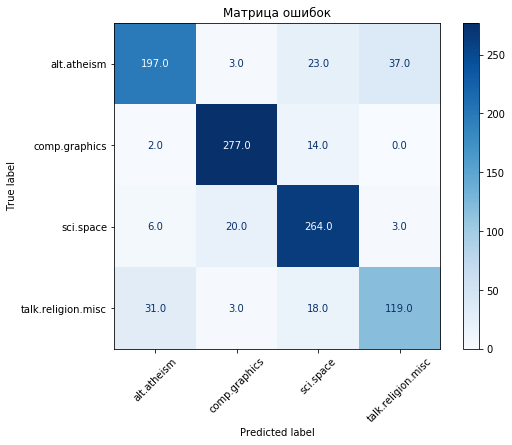

In [1682]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

Н-граммы немного улучшили лучший отчет. 

### word2vec

In [1683]:
from gensim.models import word2vec

In [1684]:
#!pip install nltk

In [1685]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/denis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/denis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1686]:
#Предобработка текста nltk
def GetTokens(text):
    # firstly let's apply nltk tokenization
    tokens = word_tokenize(text)
    # deleting stop_words   
    tokens = [i for i in tokens if (i not in stop_words)]
    # let's delete punctuation symbols
    tokens = [i for i in tokens if (i not in string.punctuation)] 
    # cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
    tokens = [i.replace("\'\'", "").replace("``", "") for i in tokens]
    return tokens

def GetSentences(data):
    sentences =[]
    stop_words = set(stopwords.words('english'))
    for line in data:
        tokens = GetTokens(line)
        sentences.append(tokens)
    return sentences

In [1687]:
#Моя предобработка текста
def format_text(txt):
    txt = re.sub('[^a-zA-Z0-9 ]', '', txt)
    txt = txt.replace('  ',' ').lower()
    return txt

In [1688]:
df['text_w2v'] = df['text'].apply(lambda t: format_text(t))

In [1689]:
#col_name = 'text' #best 0.4329 XGB
col_name = 'text_w2v' #best 0.485 XGB
#col_name = 'text_f3' #best 0.406 XGB

In [1690]:
sentences = GetSentences(df[col_name])

In [1691]:
#sentences =[]
#stop_words = set(stopwords.words('english'))
#for line in df['text']:
    # firstly let's apply nltk tokenization
#    tokens = word_tokenize(line)
#    # deleting stop_words   
#    tokens = [i for i in tokens if (i not in stop_words)]
    # let's delete punctuation symbols
#    tokens = [i for i in tokens if (i not in string.punctuation)] 
    # cleaning words
#    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
#    tokens = [i.replace("\''", "").replace("``", "") for i in tokens]
#    sentences.append(tokens)

In [1692]:
sentences[:100]

[['point',
  'set',
  'views',
  'way',
  'believe',
  'saying',
  'eveil',
  'world',
  'caused',
  'atheism',
  'ridiculous',
  'counterproductive',
  'dialogue',
  'newsgroups',
  'see',
  'posts',
  'spirit',
  'condemnation',
  'atheists',
  'newsgroup',
  'bacause',
  'dont',
  'believe',
  'exactly',
  'youre',
  'try',
  'convert',
  'atheists',
  'youre',
  'failing',
  'miserably',
  'wants',
  'position',
  'constantly',
  'defending',
  'agaist',
  'insulting',
  'attacks',
  'like',
  'seem',
  'like',
  'doim',
  'sorry',
  'youre',
  'blind',
  'didnt',
  'get',
  'messgae',
  'quote',
  'everyone',
  'else',
  'seemed'],
 ['corrupted',
  'theory',
  'pretty',
  'weak',
  'comparison',
  'thecurrent',
  'hebrew',
  'text',
  'old',
  'versions',
  'translations',
  'shows',
  'texthas',
  'fact',
  'changed',
  'little',
  'space',
  'two',
  'millennia',
  'thisshouldnt',
  'suprising',
  'people',
  'believe',
  'text',
  'mannerare',
  'likely',
  'makes',
  'pains',


In [1693]:
size=500
w2v = word2vec.Word2Vec(sentences,size=size,workers=3,window=5,min_count=1)

In [1694]:
w2v_dict = dict(zip(w2v.wv.index2word, w2v.wv.syn0))
word_vectors = pd.DataFrame(w2v.wv.vectors, index=w2v.wv.index2word)

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [1695]:
w2v.wv.vectors.shape

(67144, 500)

In [1696]:
vocab = {}
for _, key in enumerate(w2v.wv.vocab):
    vocab[key] = w2v.wv[key]

In [1697]:
w2v.wv.most_similar(positive=['atheism'], topn=5)

[('made', 0.999992311000824),
 ('great', 0.9999916553497314),
 ('religious', 0.9999902248382568),
 ('church', 0.9999902248382568),
 ('given', 0.9999899864196777)]

Сумма значений векторов предложений

In [1698]:
#Формирую матрицу статей 
feats = []
for i in range(size):
    feats.append('f' + str(i))
feats.append('target')
scaled_data = scaled_data.astype({'target':'int64'})

In [1699]:
scaled_data = pd.DataFrame(columns=[*feats], )

for index, row in df.iterrows():
    embedding = np.zeros((size,), dtype='float32')
    for token in GetTokens(row[col_name]):
        embedding = embedding + vocab[token] #Суммирую вектора всех слов в один вектор
    scaled_data.loc[index] = (*embedding,  row['target'])

In [1700]:
#На выходе мы имеем некий вектор статьи размером size и соответствующий ей target
scaled_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f491,f492,f493,f494,f495,f496,f497,f498,f499,target
0,3.215026,-25.267155,-17.503580,-12.469944,4.942965,-8.632082,8.122006,18.562241,21.085115,-21.888224,...,-9.745840,13.373001,10.223340,-11.152938,-2.563008,-1.106668,-0.541688,1.809931,12.412012,0.0
9,2.802559,-22.542257,-15.509460,-11.280397,4.444262,-7.679561,7.215361,16.610664,18.899429,-19.609163,...,-8.832643,12.207696,9.294571,-9.980830,-2.277595,-0.922237,-0.823272,1.535098,11.137198,0.0
14,0.608964,-4.625156,-3.209327,-2.279141,0.897272,-1.579700,1.507181,3.404859,3.867182,-4.008054,...,-1.784004,2.431423,1.882771,-2.030462,-0.477204,-0.196371,-0.091980,0.341700,2.278542,0.0
26,2.863615,-22.550079,-15.547492,-11.219387,4.419259,-7.679961,7.207696,16.606668,18.879284,-19.608047,...,-8.797348,12.147664,9.253942,-9.956635,-2.288516,-0.938462,-0.745131,1.575729,11.152587,0.0
27,0.427366,-3.438977,-2.348345,-1.733399,0.684129,-1.165288,1.081464,2.547800,2.891317,-3.013611,...,-1.383712,1.905485,1.451421,-1.528226,-0.337069,-0.124624,-0.185563,0.222269,1.722738,0.0


In [1701]:
scaled_data.shape

(3387, 501)

In [1723]:
X = scaled_data.drop(['target'], axis=1)
y = scaled_data['target'].astype('int')
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [1724]:
from sklearn.preprocessing import StandardScaler

In [1725]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train_orig)
scaled_test = scaler.transform(X_test_orig)

In [1726]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

In [1727]:
%%time
max_feats = int(np.sqrt(size))
clf_rfc = RandomForestClassifier(n_estimators=100,max_features=max_feats, random_state=42)

cvs3 = cross_val_score(clf_rfc , scaled_train, y_train, cv=5, scoring='accuracy')
cvs3.mean()

CPU times: user 16.2 s, sys: 204 ms, total: 16.4 s
Wall time: 16.4 s


0.45232067510548524

In [1728]:
%%time
clf_xgb = XGBClassifier()
cvs3 = cross_val_score(clf_xgb, scaled_train, y_train, cv=5, scoring='accuracy')
cvs3.mean()

CPU times: user 11min 16s, sys: 1.58 s, total: 11min 17s
Wall time: 3min 25s


0.4852320675105485

In [1729]:
%%time
clf=clf_xgb

clf.fit(scaled_train,y_train)
y_pred = clf.predict(scaled_test)

CPU times: user 2min 25s, sys: 250 ms, total: 2min 25s
Wall time: 43.9 s


In [1730]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Word2vec + sum vectors\n\n')
print(cur_rep)

Word2vec + sum vectors


                    precision    recall  f1-score   support

       alt.atheism       0.44      0.45      0.44       260
     comp.graphics       0.69      0.64      0.66       293
         sci.space       0.48      0.54      0.51       293
talk.religion.misc       0.34      0.30      0.32       171

          accuracy                           0.51      1017
         macro avg       0.49      0.48      0.48      1017
      weighted avg       0.51      0.51      0.51      1017



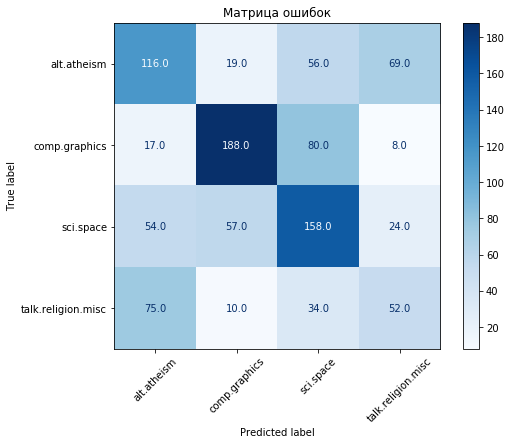

In [1734]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, scaled_test, y_test.astype(int),
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [1732]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [1733]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: -0.33

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[-0.27 -0.37 -0.32]
 [-0.25 -0.26 -0.26]
 [-0.38 -0.33 -0.35]
 [-0.44 -0.35 -0.39]]


Среднее значение векторов в предложении

In [1710]:
X = df[col_name]
y = df['target'].astype('int')
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

Т.к. сейчас мы каждому слову сопоставили вектор, то нужно решить, что сопоставить целому предложению из слов.
Один из возможных вариантов это просто усреднить все слова в предложении и получить некоторый смысл всего предложения (если слова нет в тексте, то берем нулевой вектор).

In [1711]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v_dict.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [1712]:
X_train = mean_vectorizer(w2v).fit(X_train_orig).transform(X_train_orig)
X_test = mean_vectorizer(w2v).fit(X_test_orig).transform(X_test_orig)

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [1713]:
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [1714]:
%%time
max_feats = int(np.sqrt(size))
clf_rfc = RandomForestClassifier(n_estimators=100,max_features=max_feats, random_state=42)

cvs3 = cross_val_score(clf_rfc , scaled_train, y_train, cv=5, scoring='accuracy')
cvs3.mean()

CPU times: user 16.6 s, sys: 7.98 ms, total: 16.6 s
Wall time: 16.6 s


0.3822784810126582

In [1715]:
%%time
clf_xgb = XGBClassifier()
cvs3 = cross_val_score(clf_xgb, scaled_train, y_train, cv=5, scoring='accuracy')
cvs3.mean()

CPU times: user 11min 28s, sys: 1.13 s, total: 11min 29s
Wall time: 3min 19s


0.40168776371308024

In [1716]:
%%time
clf=clf_rfc

clf.fit(scaled_train,y_train)
y_pred = clf.predict(scaled_test)

CPU times: user 4.33 s, sys: 6 µs, total: 4.33 s
Wall time: 4.33 s


In [1717]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Word2vec + mean vectors\n\n')
print(cur_rep)

Word2vec + mean vectors


                    precision    recall  f1-score   support

       alt.atheism       0.39      0.38      0.39       260
     comp.graphics       0.53      0.56      0.54       293
         sci.space       0.39      0.41      0.40       293
talk.religion.misc       0.27      0.23      0.25       171

          accuracy                           0.41      1017
         macro avg       0.40      0.40      0.39      1017
      weighted avg       0.41      0.41      0.41      1017



In [1156]:
#https://gitlab.com/AlexBut/course-task/-/blob/master/Project.ipynb - тут есть примеры работы с word2vec
#https://machinelearningmastery.com/develop-word-embeddings-python-gensim/